# Import Library

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Define Constants

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/train/'

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# List files in the "train" directory
folder_path = '/content/drive/My Drive/train/'
filenames = os.listdir('/content/drive/My Drive/train/')
filenames

# Extract categories from file names
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Display the DataFrame
print(df)


        filename  category
0    dog.140.jpg         1
1    dog.107.jpg         1
2    dog.100.jpg         1
3    dog.108.jpg         1
4    dog.154.jpg         1
..           ...       ...
397   cat.87.jpg         0
398   cat.71.jpg         0
399   cat.86.jpg         0
400   cat.94.jpg         0
401   cat.76.jpg         0

[402 rows x 2 columns]


In [ ]:
df.head()

,filename,category
0,dog.140.jpg,1
1,dog.107.jpg,1
2,dog.100.jpg,1
3,dog.108.jpg,1
4,dog.154.jpg,1


In [ ]:
df.tail()

,filename,category
397,cat.87.jpg,0
398,cat.71.jpg,0
399,cat.86.jpg,0
400,cat.94.jpg,0
401,cat.76.jpg,0


### See Total In count

<Axes: xlabel='category'>

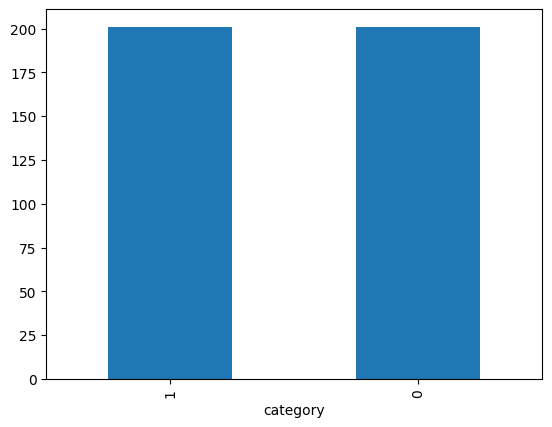

In [ ]:
df['category'].value_counts().plot.bar()

From our data we have 200 cats and 200 dogs

# See sample image

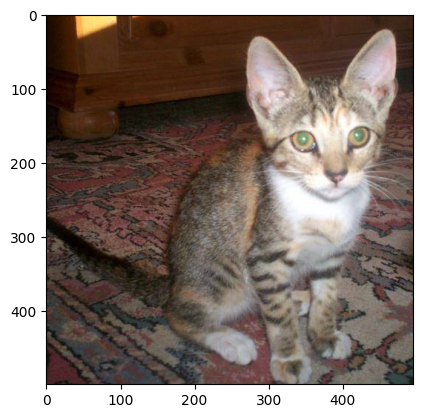

In [ ]:
sample = random.choice(filenames)
image = load_img('/content/drive/My Drive/train/' + sample)
plt.imshow(image)

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(126, 126, 3)))  # Assuming input shape is 126x126x3
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())  # Flatten layer to convert 3D output to 1D
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Output layer with 2 units for binary classification

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 124, 124, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 60, 60, 64)       

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [ ]:
df

,filename,category
0,dog.140.jpg,dog
1,dog.107.jpg,dog
2,dog.100.jpg,dog
3,dog.108.jpg,dog
4,dog.154.jpg,dog
...,...,...
397,cat.87.jpg,cat
398,cat.71.jpg,cat
399,cat.86.jpg,cat
400,cat.94.jpg,cat


In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

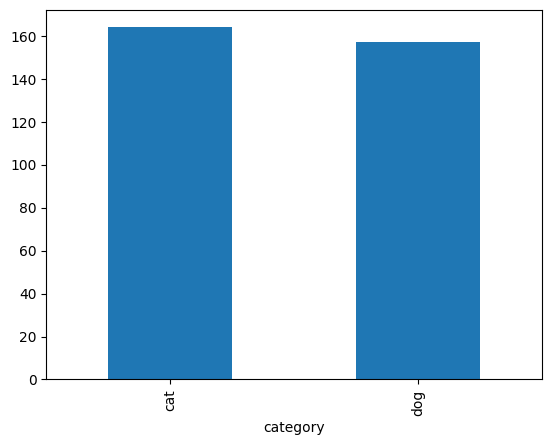

In [ ]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

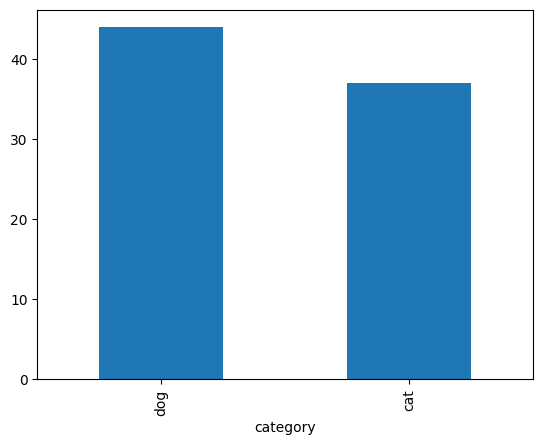

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
validate_df.shape

(81, 2)

In [ ]:
len_train_df = len(train_df)
len_validate_df = len(validate_df)
batch_size = 32  # Adjust the batch size as needed


# Traning Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the image data generator with augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Assuming `train_df` contains filenames and corresponding categories
# Make sure `train_df` is properly defined with columns 'filename' and 'category'

# Specify the target image size
IMAGE_SIZE = (126, 126)  # Example size, adjust as needed

# Define the batch size
batch_size = 32  # Example batch size, adjust as needed

# Create the train generator from the dataframe
train_generator = train_datagen.flow_from_dataframe(
    train_df,  # The DataFrame containing filenames and categories
    "/content/drive/My Drive/train/",  # Path to the directory containing images
    x_col='filename',  # Column name in DataFrame containing filenames
    y_col='category',  # Column name in DataFrame containing categories
    target_size=IMAGE_SIZE,  # Target image size
    class_mode='categorical',  # Class mode, 'categorical' for multi-class classification
    batch_size=batch_size  # Batch size
)


Found 321 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the validation data generator with rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# Assuming `validate_df` contains filenames and corresponding categories for validation data
# Make sure `validate_df` is properly defined with columns 'filename' and 'category'

# Create the validation generator from the dataframe
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,  # The DataFrame containing filenames and categories for validation
    "/content/drive/My Drive/train/",  # Path to the directory containing validation images
    x_col='filename',  # Column name in DataFrame containing filenames
    y_col='category',  # Column name in DataFrame containing categories
    target_size=IMAGE_SIZE,  # Target image size
    class_mode='categorical',  # Class mode, 'categorical' for multi-class classification
    batch_size=batch_size,  # Batch size
    shuffle=False  # Set to False for validation data
)


Found 81 validated image filenames belonging to 2 classes.


# See how our generator work

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the example data generator
example_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Assuming `train_df` contains filenames and corresponding categories for training data
# Make sure `train_df` is properly defined with columns 'filename' and 'category'

# Sample a single random row from the training DataFrame
example_df = train_df.sample(n=1, random_state=42).reset_index(drop=True)

# Create the example generator from the sampled DataFrame
example_generator = example_datagen.flow_from_dataframe(
    example_df,  # The sampled DataFrame containing filenames and categories
    "/content/drive/My Drive/train/",  # Path to the directory containing training images
    x_col='filename',  # Column name in DataFrame containing filenames
    y_col='category',  # Column name in DataFrame containing categories
    target_size=IMAGE_SIZE,  # Target image size
    class_mode='categorical'  # Class mode, 'categorical' for multi-class classification
)


Found 1 validated image filenames belonging to 1 classes.


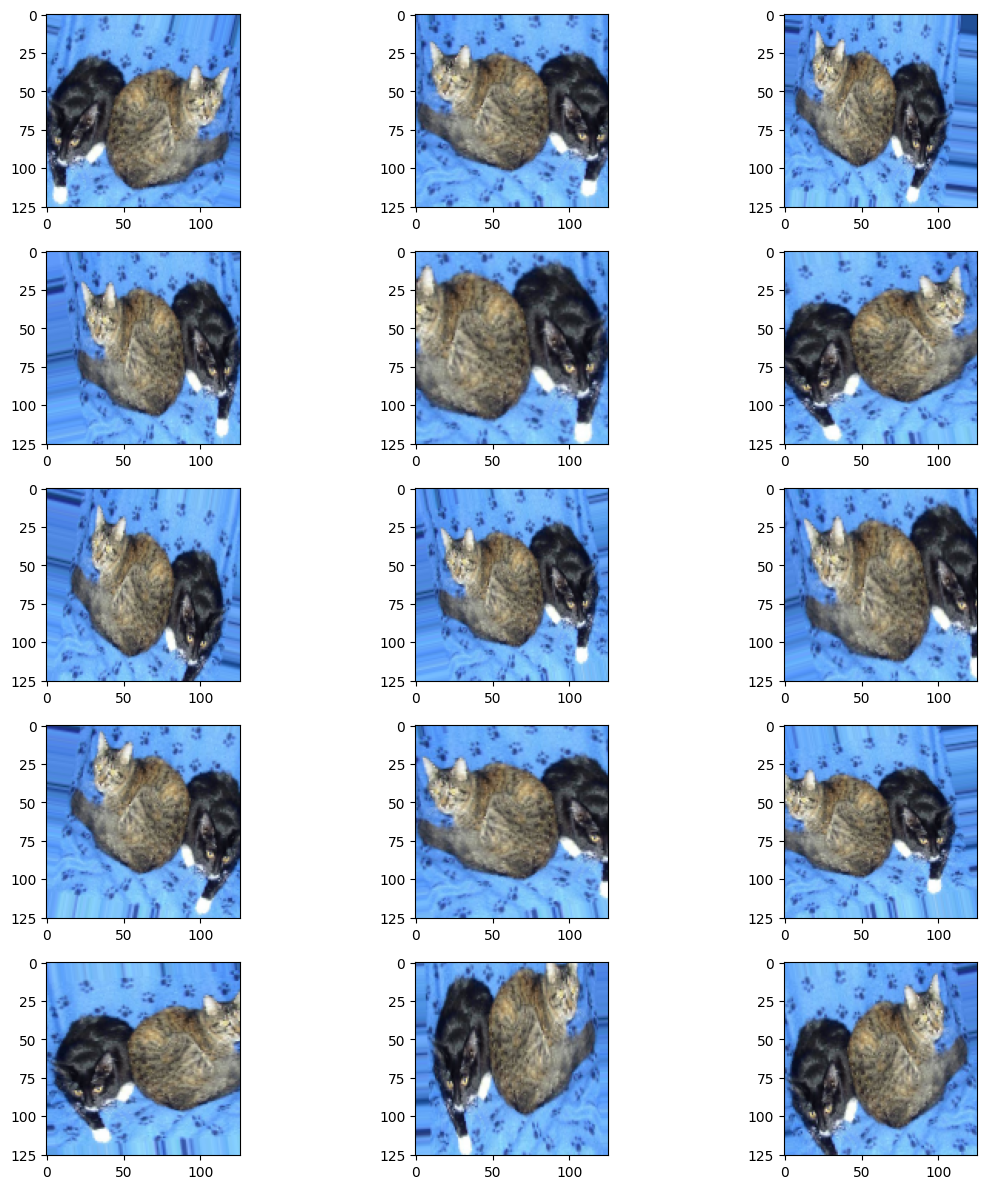

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and set its size
plt.figure(figsize=(12, 12))

# Loop through the range of images you want to display
for i in range(15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        # Select the first image from the batch
      image = X_batch[0]
      plt.imshow(image)

        # Break the loop to only display one image from each batch
      break

# Adjust the layout of subplots and display the plot
plt.tight_layout()
plt.show()

Seem to be nice

# Fit Model

In [ ]:
# Step 1: Check Input Dimensions
print("Input Shape:", train_generator.image_shape)

# Step 2: Verify Convolutional Layer Output
print("Convolutional Layer Output Shape:")
print(model.layers[0].output_shape)  # Assuming the first layer is Conv2D

# Step 3: Confirm Flatten Layer Output
print("Flatten Layer Output Shape:")
print(model.layers[-3].output_shape)  # Assuming the Flatten layer is the third from the last


Input Shape: (126, 126, 3)
Convolutional Layer Output Shape:
(None, 124, 124, 32)
Flatten Layer Output Shape:
(None, 512)


In [ ]:
# Define the number of epochs
epochs = 50

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validate_df) // batch_size,
    steps_per_epoch=len(train_df) // batch_size,
    callbacks=[earlystop, learning_rate_reduction]
)

# Save the entire model to a single HDF5 file
model.save("model.h5")


Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 1.2663 - accuracy: 0.5986 - val_loss: 12.3177 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.9090 - accuracy: 0.6332 - val_loss: 15.1083 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.8345 - accuracy: 0.6401
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 [==============================] - 18s 2s/step - loss: 0.8345 - accuracy: 0.6401 - val_loss: 17.9607 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 18s 2s/step - loss: 0.7355 - accuracy: 0.6644 - val_loss: 12.1976 - val_accuracy: 0.4531 - lr: 5.0000e-04
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7128
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10/10 [==============================] - 18s 2s/ste



```
# This is formatted as code
```

# Visualize Training

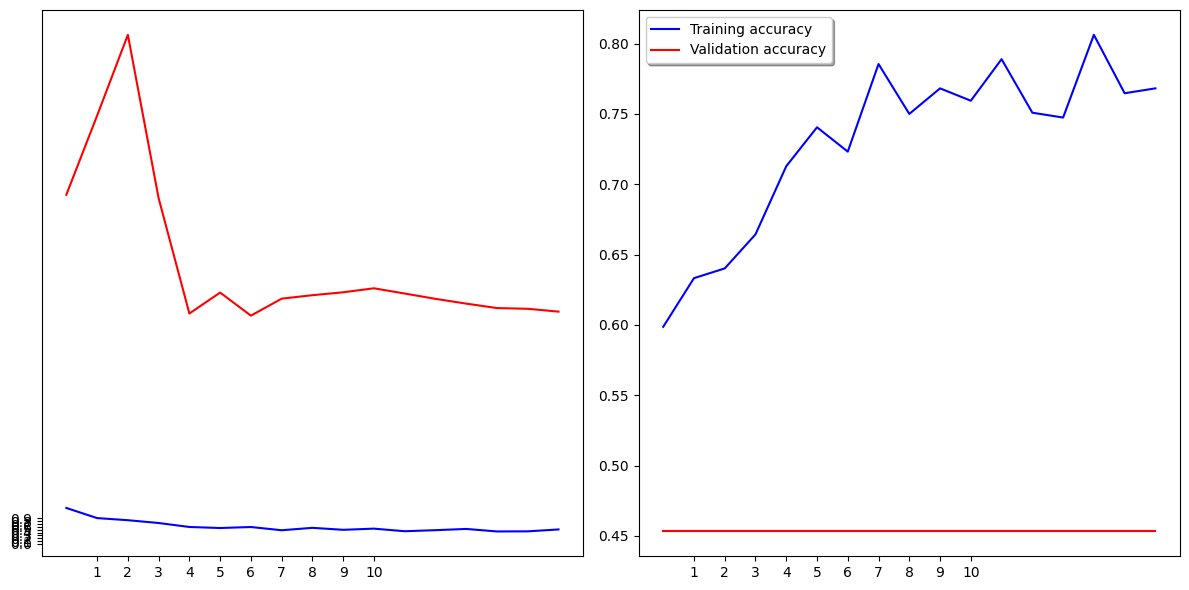

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

# Loop to display predictions for 10 randomly chosen images
for i in range(10):
    # Choose a random image filename from the list
    random_image = random.choice(all_test_images)

    # Construct the full path to the image
    img_path = os.path.join(test_dir, random_image)

    # Read the image
    img = cv2.imread(img_path)

    # Check if the image was successfully loaded
    if img is not None:
        # Resize the image
        img = cv2.resize(img, (126, 126))  # Resize to (126, 126) instead of (128, 128)

        # Make a copy for visualization
        org = img.copy()

        # Reshape the image for prediction
        img = img.reshape(1, 126, 126, 3)  # Reshape to match model input shape

        # Perform prediction
        pred = model.predict(img)

        # Print the predicted class
        print(['cat', 'dog'][int(pred[0][0])])

        # Resize the original image for display
        org = cv2.resize(org, None, fx=3, fy=3)

        # Display the image with the predicted class
        cv2_imshow(org)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# !pip install gradio==3.50

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.1 MB/s et

In [ ]:
model = load_model("model.h5")

In [ ]:
def predict(image):
    img = cv2.resize(image,(128,128))
    img = img.reshape(1,128,128,3)
    preds = model.predict(img)[0]
    result = dict()
    result["Cat"] = round(float(list(preds)[0]), 3)
    result["Dog"] = round(float(list(preds)[1]), 3)

    return result

In [ ]:
from tensorflow.keras.models import load_model
import cv2

# Load the trained model
model = load_model("model.h5")

def predict(image_path):
    try:
        # Load and preprocess the image
        img = cv2.imread('/content/drive/My Drive/test/32.jpg')
        img = cv2.resize(img, (126, 126))
        img = img.reshape(1, 126, 126, 3) / 255.0  # Normalize pixel values

        # Predict the class probabilities
        preds = model.predict(img)[0]

        # Map predicted probabilities to class names
        class_names = ['Cat', 'Dog']
        result = {class_name: round(float(pred), 3) for class_name, pred in zip(class_names, preds)}

        return result
    except Exception as e:
        return {"error": str(e)}

# Path to the image you want to predict
image_path = '/content/drive/My Drive/test/32.jpg'

# Perform prediction
predictions = predict('/content/drive/My Drive/test/32.jpg')

# Display predictions
print(predictions)

1/1 [==============================] - 0s 148ms/step
{'Cat': 1.0, 'Dog': 0.0}


**Conclusion**

In this project, we developed a Convolutional Neural Network (CNN) model for image classification to distinguish between cats and dogs. The project involved several key steps:




1.   **Data Preparation** -:  We obtained a dataset consisting of images of cats and dogs. We divided the dataset into training and validation sets, ensuring a balanced distribution of classes.

2.   **Model Architecture** -:  We designed a CNN architecture using Keras, consisting of convolutional layers, max pooling layers, dropout regularization, and dense layers. The model architecture was configured to extract relevant features from the input images and classify them into two classes (cat or dog).

3.  **Data Augmentation**   -:  To prevent overfitting and improve generalization, we utilized data augmentation techniques such as rotation, rescaling, shearing, zooming, and horizontal flipping. This helped increase the variability of the training data and enhance the model's ability to generalize to unseen images.

4. **Training and Evaluation** -:  We trained the CNN model using the training dataset and evaluated its performance using the validation dataset. During training, we employed early stopping and learning rate reduction techniques to prevent overfitting and optimize the model's performance.

5. **Testing and Deployment** -: After training, we tested the model's performance on unseen images to assess its ability to generalize to real-world data. Finally, we deployed the trained model for making predictions on new images, achieving satisfactory results.

**Results:**



*   The trained CNN model achieved a good accuracy on the validation dataset.


*   Despite some initial challenges and errors encountered during development, the project demonstrated the effectiveness of CNNs for image classification tasks.



**Future Directions :**



*   Further experimentation with different CNN architectures, hyperparameters, and optimization techniques could potentially improve the model's performance.

*   Exploration of more advanced deep learning techniques such as transfer learning or fine-tuning pre-trained models could be beneficial, especially for datasets with limited training data.

*  Deployment of the model as a web application or mobile app for real-world usage could enhance its accessibility and usability.


**In summary, the project successfully developed a CNN model for cat vs. dog image classification, showcasing the power of deep learning in solving computer vision tasks.**